In [36]:
import networkx as nx
import networkx.algorithms.community as nxcom
import pickle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
from IPython.display import display, clear_output
import numpy as np

In [13]:
with open('../4_Sargons_Pen_Pals/pickle/treasury.p', 'rb') as f: 
    G = pickle.load(f)

In [22]:
Aradnannak = ['AradNannak[0]PN', 'Aradnanna[0]PN', 'Aradŋu[0]PN', 'sukkalmah[official]N']

In [23]:
for name in Aradnannak[1:]: 
    G = nx.contracted_nodes(G, 'AradNannak[0]PN', name)

In [25]:
eigenvector = nx.eigenvector_centrality(G)
degree_centrality = nx.degree_centrality(G)
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
hub, authority = nx.hits(G, max_iter=600)

In [26]:
centrality = [eigenvector, degree_centrality, in_degree_centrality, out_degree_centrality, closeness_centrality, betweenness_centrality, hub, authority]
centrality_labels = ["eigenvector", "degree centrality", "in degree centrality",
                     "out degree centrality", "closeness centrality",
                     "betweenness centrality", "hub", "authority"]
for idx, m in enumerate(centrality):
    s = sorted(m, key=m.get, reverse=True)[:5]
    print(f"{centrality_labels[idx]}: {s}")

eigenvector: ['lugal[king]N', 'Ludiŋirak[0]PN', 'Lugalkugzu[0]PN', 'AradNannak[0]PN', 'Šušulgir[0]PN']
degree centrality: ['Ludiŋirak[0]PN', 'PuzurErra[0]PN', 'AradNannak[0]PN', 'lugal[king]N', 'Dayyanummišar[0]PN']
in degree centrality: ['Ludiŋirak[0]PN', 'Lugalkugzu[0]PN', 'lugal[king]N', 'PuzurErra[0]PN', 'Lunanna[0]PN']
out degree centrality: ['Ludiŋirak[0]PN', 'PuzurErra[0]PN', 'AradNannak[0]PN', 'Dayyanummišar[0]PN', 'lugal[king]N']
closeness centrality: ['lugal[king]N', 'Lugalkugzu[0]PN', 'Ludiŋirak[0]PN', 'PuzurErra[0]PN', 'AradNannak[0]PN']
betweenness centrality: ['Ludiŋirak[0]PN', 'lugal[king]N', 'PuzurErra[0]PN', 'AradNannak[0]PN', 'Dayyanummišar[0]PN']
hub: ['lugal[king]N', 'Amurili[0]PN', 'Ulu₃.lal₃[00]PN', 'Ludiŋirak[0]PN', 'Ayaŋu[0]PN']
authority: ['Ludiŋirak[0]PN', 'PuzurErra[0]PN', 'ME.Ištaran[0]PN', 'Kubatum[0]PN', 'Šuenlil[0]PN']


In [29]:
H = nx.DiGraph.to_undirected(G)
k_clique_com = sorted(nxcom.k_clique_communities(H, 4), key=len, reverse=True)
# Count the communities
N = len(k_clique_com)
print(f"The graph has {N} clique communities.")

The graph has 3 clique communities.


In [31]:
nx.set_node_attributes(H, {0}, "cliques") # set {0} as default
for c, v_c in enumerate(k_clique_com):
    for v in v_c:
        if min(H.nodes[v]['cliques']) > 0:  # node is already in a clique
            H.nodes[v]['cliques'].add(c+1) # add clique no. to the set
        else:
            H.nodes[v]['cliques'] = {c+1}
        # Add 1 to save 0 for nodes that are not in a clique

In [32]:
nx.set_edge_attributes(H, 0, "clique")  # default is 0
for v, w, in H.edges:
    c = H.nodes[v]['cliques'].intersection(H.nodes[w]['cliques']) # do the two nodes share a community?
    if c:
        # Internal edge, mark with community
        H.edges[v, w]['clique'] = min(c)

In [33]:
nodes = [x for x, y in H.nodes(data=True) if min(y["cliques"]) > 0 or y["degree"] > 8] # select nodes
I = H.subgraph(nodes)

In [34]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map
    https://gist.github.com/jakevdp/91077b0cae40f8f8244a
    by Jake VanderPlas"""
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    return color_list

In [37]:
colmap = discrete_cmap(N+2, "jet")
colmap[0] = [0, 0, 0, 1]  # 0 = black

In [38]:
node_color = [colmap[min(I.nodes[v]['cliques'])] if len(I.nodes[v]['cliques'])==1 else colmap[N+1] for v in I.nodes]
edge_color = [colmap[I.edges[v, w]['clique']] for v, w in I.edges]

In [40]:
labels = nx.get_node_attributes(I, 'name')

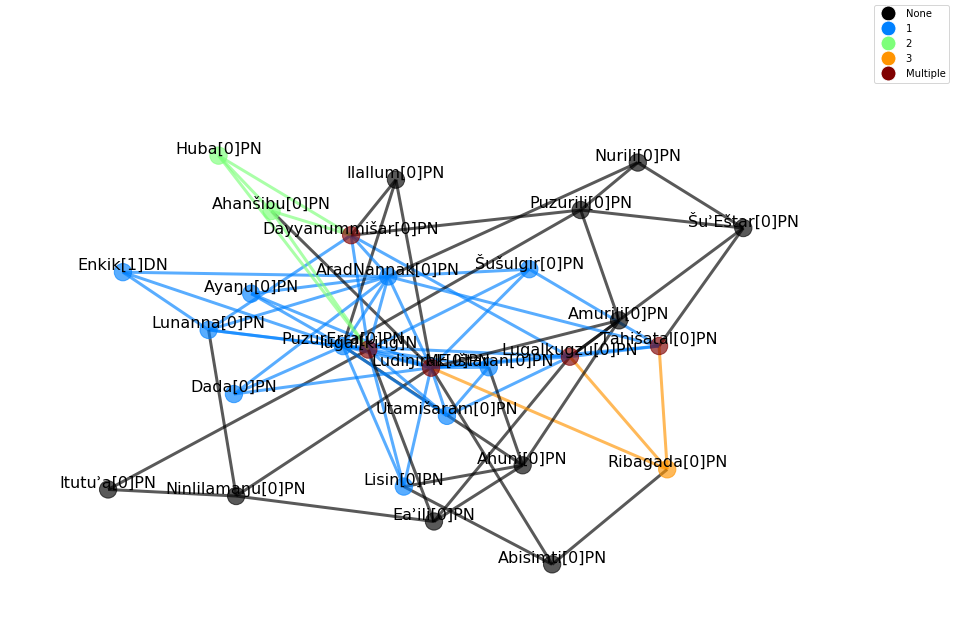

In [41]:
label_pos = {}
pos = nx.spring_layout(I)
for k, v in pos.items():   # shift position of label slightly away from the node
    label_pos[k] = (v[0], v[1]+0.03)
fig = plt.figure(figsize=(15, 10))
plt.gca().margins(0.15, 0.15) # provide margins to prevent labels from going over the edge
nx.draw(
        I,
        pos=pos,
        node_color=node_color,
        edge_color=edge_color, 
        #node_size = node_size, 
        with_labels = False,
        cmap = colmap, 
        width = 3, 
        alpha = .65
        #cmap= plt.cm.jet
        )
nx.draw_networkx_labels(I, label_pos, labels, font_size=16)
# the following are fake "lines" used to create the legend.
legend_elements = [Line2D([1], [0], marker='o', color='w', label=str(i+1),
                          markerfacecolor=colmap[i+1], markersize=15) for i, c in enumerate(k_clique_com)]
no_com = [Line2D([0], [0], marker='o', color='w', label="None",
                          markerfacecolor=colmap[0], markersize=15)]
mult_com = [Line2D([0], [0], marker='o', color='w', label="Multiple",
                          markerfacecolor=colmap[N+1], markersize=15)]
legend_elements = no_com + legend_elements + mult_com
fig.legend(handles=legend_elements)
plt.show()